In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
# Generate training data

In [6]:
def generate_training_data(num_interior_points, num_boundary_points):
    x_interior = np.random.uniform(0.1, 0.9, num_interior_points)[:, None]
    x_boundary = np.array([[0.], [1.]])  # Fixed boundary points
    return x_interior, x_boundary

In [7]:
# PINN model architecture

In [8]:
class PINNModel(tf.keras.Model):
    def __init__(self):
        super(PINNModel, self).__init__()
        self.dense_layer_1 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense_layer_2 = tf.keras.layers.Dense(50, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1)
        
    def call(self, x):
        x = self.dense_layer_1(x)
        x = self.dense_layer_2(x)
        return self.output_layer(x)

In [9]:
def physics_informed_loss(model, x_interior, x_boundary):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_interior)
        tape.watch(x_boundary)
        u_interior = model(x_interior)
        u_boundary = model(x_boundary)
        u_interior_gradient = tape.gradient(u_interior, x_interior)
        u_interior_dx2 = tape.gradient(u_interior_gradient, x_interior)
    
    # Define the PDE constraint (heat conduction equation + Darcy's law)
    pde_residual = u_interior_gradient
    pde_residual = tape.gradient(u_interior_dx2, x_interior)
    
    # Define the boundary condition constraints
    boundary_residual_left = u_boundary[0]  # Boundary condition at x=0
    boundary_residual_right = u_boundary[1]  # Boundary condition at x=1
    
    # Define the initial condition constraint
    initial_condition_residual = model(tf.constant([[0.]], dtype=tf.float32)) - 1.0  # Initial condition at t=0
    
    # Compute the loss as a combination of PDE, boundary, and initial condition residuals
    loss = tf.reduce_mean(tf.square(pde_residual)) + \
           tf.reduce_mean(tf.square(boundary_residual_left)) + \
           tf.reduce_mean(tf.square(boundary_residual_right)) + \
           tf.reduce_mean(tf.square(initial_condition_residual))
    
    return loss

In [10]:
# Train the PINN model

In [11]:
def train(model, x_train_interior, x_train_boundary, epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = physics_informed_loss(model, x_train_interior, x_train_boundary)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.numpy()}')

In [12]:
# Generate training data

In [13]:
num_interior_points = 1000
num_boundary_points = 2
x_train_interior, x_train_boundary = generate_training_data(num_interior_points, num_boundary_points)

In [14]:
# Convert training data to TensorFlow tensors

In [15]:
x_train_interior_tf = tf.convert_to_tensor(x_train_interior, dtype=tf.float32)
x_train_boundary_tf = tf.convert_to_tensor(x_train_boundary, dtype=tf.float32)

In [16]:
# Create PINN model

In [17]:
model = PINNModel()

In [18]:
train(model, x_train_interior_tf, x_train_boundary_tf, epochs=1000)

Epoch 0, Loss: 1.0643234252929688
Epoch 100, Loss: 0.5004481673240662
Epoch 200, Loss: 0.5002601146697998
Epoch 300, Loss: 0.5001729726791382
Epoch 400, Loss: 0.5001240968704224
Epoch 500, Loss: 0.5000937581062317
Epoch 600, Loss: 0.500073254108429
Epoch 700, Loss: 0.5000584125518799
Epoch 800, Loss: 0.5000467300415039
Epoch 900, Loss: 0.5000369548797607


In [19]:
model.summary()

Model: "pinn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  100       
                                                                 
 dense_1 (Dense)             multiple                  2550      
                                                                 
 dense_2 (Dense)             multiple                  51        
                                                                 
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________


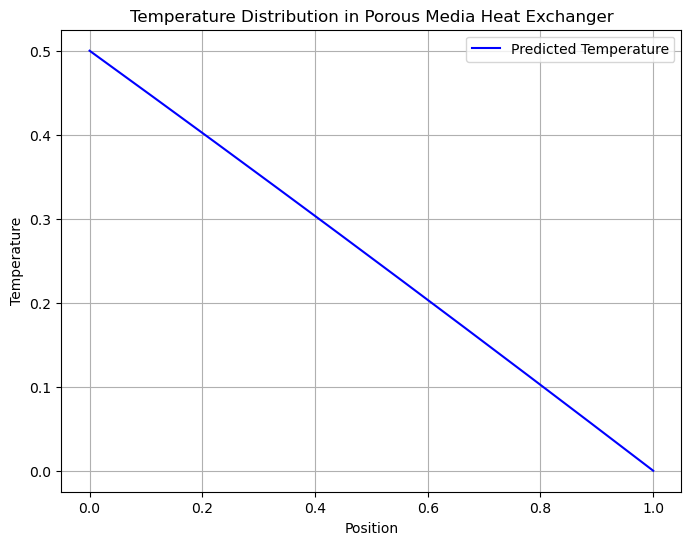

In [27]:
# Generate points for visualization
x_plot = np.linspace(0, 1, 10)[:, None]
x_plot_tf = tf.convert_to_tensor(x_plot, dtype=tf.float32)

# Predict temperature using the trained model
temperature_prediction = model(x_plot_tf).numpy()

# Plot the temperature distribution
plt.figure(figsize=(8, 6))
plt.plot(x_plot, temperature_prediction, label='Predicted Temperature', color='blue')
plt.xlabel('Position')
plt.ylabel('Temperature')
plt.title('Temperature Distribution in Porous Media Heat Exchanger')
plt.grid(True)
plt.legend()
plt.show()

In [29]:
#Analytical solution

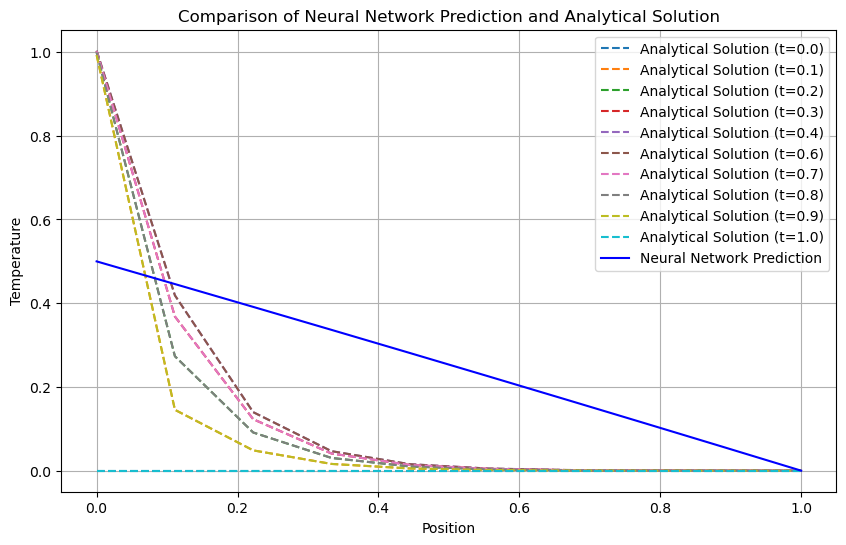

In [28]:
# Define the analytical solution function
def analytical_solution(x, t, n_terms=100):
    u = np.zeros_like(x)
    for n in range(1, n_terms + 1):
        u += (4 / (2 * n - 1) / np.pi) * np.sin((2 * n - 1) * np.pi * x) * np.exp(-(2 * n - 1)**2 * np.pi**2 * t)
    return u

# Generate points for visualization
x_plot = np.linspace(0, 1, 10)[:, None]
t_plot = np.linspace(0, 1, 10)
x_mesh, t_mesh = np.meshgrid(x_plot, t_plot)

# Calculate analytical solution
u_analytical = analytical_solution(x_mesh, t_mesh)

# Predict temperature using the trained model
temperature_prediction = model(x_plot_tf).numpy()

# Plot the temperature distribution
plt.figure(figsize=(10, 6))
for i in range(len(t_plot)):
    plt.plot(x_plot, u_analytical[:, i], label=f'Analytical Solution (t={t_plot[i]:.1f})', linestyle='--')
plt.plot(x_plot, temperature_prediction, label='Neural Network Prediction', color='blue')
plt.xlabel('Position')
plt.ylabel('Temperature')
plt.title('Comparison of Neural Network Prediction and Analytical Solution')
plt.grid(True)
plt.legend()
plt.show()
